[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ASKabalan/jax-hpc-profiler/blob/main/examples/profiling.ipynb)

### Profiling JAX HPC Profiler with Timer and Visualization Tools

This notebook demonstrates how to use the `jax_hpc_profiler` package for performance profiling of JAX and NumPy functions. The workflow includes benchmarking, generating CSV reports, and visualizing weak scaling results.



In [1]:
try:
    import google.colab  # ignore: F401

    !pip install -q jax-hpc-profiler 
except ImportError:
    pass  # Not in Colab

In [2]:
import jax
import jax.numpy as jnp
import numpy as np

from jax_hpc_profiler import Timer

OUTPUT_PATH = 'jax_hpc_profiler_report'

### **Defining JAX and NumPy Functions**

This cell defines computational functions for matrix operations. JAX functions utilize `@jax.jit` for just-in-time compilation, while equivalent NumPy functions serve as benchmarks for comparison.

In [3]:
# Define JAX functions
@jax.jit
def mma(m, n, k):
    return jnp.dot(m, n) + k


@jax.jit
def inv(m):
    return jnp.linalg.inv(m)


# Define NumPy functions
def numpy_mma(m, n, k):
    return np.dot(m, n) + k


def numpy_inv(m):
    return np.linalg.inv(m)

### **Profiling JAX and NumPy Functions Across Matrix Sizes**

This cell initializes two `Timer` objects from the `jax_hpc_profiler` package for profiling JAX and NumPy functions. A range of matrix sizes, from 100x100 to 1000x1000, is evaluated to compare the performance of JAX and NumPy implementations of matrix operations.

- **JAX Profiling**:  
  The JAX timer measures the execution time of just-in-time compiled (`@jax.jit`) functions for matrix multiplication-addition (`mma`) and matrix inversion (`inv`). The results are saved in a `JAX.csv` file with metadata.

- **NumPy Profiling**:  
  The NumPy timer benchmarks the equivalent operations using standard NumPy functions. Execution times are saved in a `NUMPY.csv` file for comparison.

Both profiling workflows repeat each operation 10 times for more reliable measurements, and results are reported with associated metadata such as matrix size and precision.

In [4]:
# Initialize timers
jax_timer = Timer(save_jaxpr=True, jax_fn=True)
numpy_timer = Timer(save_jaxpr=False, jax_fn=False)

# Profiling matrix sizes from 100x100 to 1000x1000
for size in range(100, 1001, 100):
    # JAX Matrices
    m_jax = jnp.ones((size, size))
    n_jax = jnp.ones((size, size))
    k_jax = jnp.ones((size, size))
    rand_jax = jax.random.normal(jax.random.key(0), (size, size))

    # NumPy Matrices
    m_np = np.ones((size, size))
    n_np = np.ones((size, size))
    k_np = np.ones((size, size))
    rand_np = np.random.rand(size, size)

    # --- JAX profiling ---
    jax_timer.chrono_jit(mma, m_jax, n_jax, k_jax)
    for _ in range(10):
        jax_timer.chrono_fun(mma, m_jax, n_jax, k_jax)

    kwargs = {'function': 'mma', 'precision': 'float32', 'x': size, 'y': size}
    extra_info = {'done': 'yes'}
    jax_timer.report(f'{OUTPUT_PATH}/JAX.csv', **kwargs, extra_info=extra_info)

    jax_timer.chrono_jit(inv, rand_jax)
    for _ in range(10):
        jax_timer.chrono_fun(inv, rand_jax)

    kwargs = {'function': 'inv', 'precision': 'float32', 'x': size, 'y': size}
    jax_timer.report(f'{OUTPUT_PATH}/JAX.csv', **kwargs, extra_info=extra_info)

    # --- NumPy profiling ---
    for _ in range(10):
        numpy_timer.chrono_fun(numpy_mma, m_np, n_np, k_np)

    kwargs = {'function': 'mma', 'precision': 'float32', 'x': size, 'y': size}
    numpy_timer.report(f'{OUTPUT_PATH}/NUMPY.csv', **kwargs, extra_info=extra_info)

    for _ in range(10):
        numpy_timer.chrono_fun(numpy_inv, rand_np)

    kwargs = {'function': 'inv', 'precision': 'float32', 'x': size, 'y': size}
    numpy_timer.report(f'{OUTPUT_PATH}/NUMPY.csv', **kwargs, extra_info=extra_info)

### **Visualizing Scaling Performance (single-device focus)**  

This notebook profiles JAX and NumPy on a single host. Use `plot_by_gpus` to create subplots per GPU count with data size on the x-axis.

For multi-GPU scaling with subplots per data size (strong scaling view), see `examples/distributed_profiling.ipynb` (uses `JAX_MULTI.csv`).


In [5]:
import os
import sys

for rel in ('src', os.path.join('..', 'src')):
    path = os.path.abspath(rel)
    if os.path.isdir(path) and path not in sys.path:
        sys.path.insert(0, path)

from jax_hpc_profiler.plotting import plot_by_gpus

### **Filtering Options for `plot_by_gpus` Visualization**

Use `plot_by_gpus` to visualize how runtime changes with data size at each GPU count (one subplot per GPU count, x-axis = data size). You can filter by data size, GPU count, function, precision, and decomposition strategy.

For subplots per data size with GPUs on the x-axis, use `plot_by_data_size` (see the distributed notebook).


### **Scaling Plots via Command Line**

`-sc GPUs` creates subplots per GPU count with data size on the x-axis. `-sc data` creates subplots per data size with GPUs on the x-axis.

**Subplots per GPU count (size scaling at fixed GPUs):**

```bash
!jhp plot -f NUMPY.csv JAX.csv -d 100 200 300 -sc GPUs -pt mean_time -o jax_hpc_profiler_report/scaling.png -l "%m%-%f%"
```

This command filters by data sizes (`-d 100 200 300`), uses GPU-count subplots (`-sc GPUs`), selects `mean_time` (`-pt mean_time`), and saves the plot (`-o scaling.png`).

**Subplots per data size (strong scaling view):**

```bash
!jhp plot -f MYDATA.csv -pt mean_time -sc data -d 128 256 512 --ideal_line
```

Use `--ideal_line` to overlay an ideal scaling reference line.


```bash
!jhp plot -f jax_hpc_profiler_report/NUMPY.csv jax_hpc_profiler_report/JAX.csv -d 100 200 300 -sc GPUs -pt mean_time -o jax_hpc_profiler_report/scaling.png -l "%m%-%f%"
```


# Plotting using Python API

You can also generate scaling plots directly using the Python API:

requested GPUS: None available GPUS: {np.int64(1)}
requested data sizes: None available global volumes: {np.int64(1000000), np.int64(8000000), np.int64(64000000), np.int64(125000000), np.int64(27000000), np.int64(216000000), np.int64(343000000), np.int64(512000000), np.int64(729000000), np.int64(1000000000)}


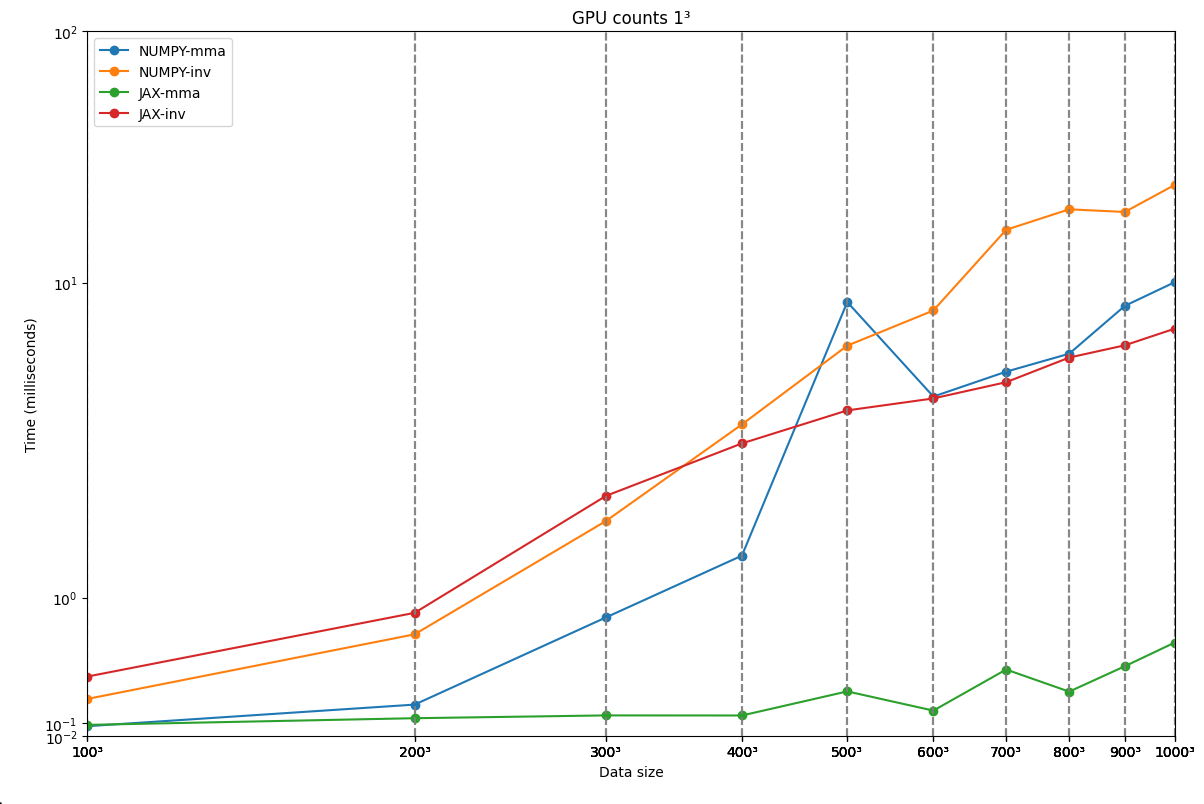

In [9]:
from pathlib import Path

csv_paths = [Path('jax_hpc_profiler_report/NUMPY.csv'), Path('jax_hpc_profiler_report/JAX.csv')]
if all(p.exists() for p in csv_paths):
    plot_by_gpus(
        csv_files=[str(p) for p in csv_paths],
        figure_size=(12, 8),
        label_text='%m%-%f%',
        xscale='log10',
    )
else:
    print('CSV files not found; skipping plot example.')

### **Handling Multiple Outputs in JAX Functions**

You can also profile JAX functions that return multiple outputs.\
The profiler will block until all outputs are computed to ensure accurate timing.


In [10]:
@jax.jit
def multi_out(x, y):
    return x + y, x - y


timer = Timer()

timer.chrono_jit(multi_out, 1, 2)

(Array(3, dtype=int32, weak_type=True), Array(-1, dtype=int32, weak_type=True))